# CIS 5450 Homework 3: Spark SQL

### **Deadline: Monday, 23rd, October 2023 @ 10pm EST**

#### **Worth 100 points**

Welcome to CIS 5450 Homework 3! In this homework you will gain a mastery of using Spark SQL. By the end, you'll be a star (not that you aren't already one). Over the next few days you will be using an EMR cluster to use Spark to manipulate the datasets about Amazon products and their reviews.

## The Necessary Notes and Nags
Before we begin here are some important notes to keep in mind,


1.   **IMPORTANT!** I said it twice, it's really important. In this homework, we will be using AWS resources. You are given a quota ($100) to use for the entirety of the homework. There is a small chance you will use all this money, however it is important that at the end of every session, you **shut down your EMR cluster**.
2.   **Be sure you use Google Colab for this Homework** since we must connect to the EMR cluster and local Jupyter will have issues doing that. Using a Google Colab Notebook with an EMR cluster has two important abnormalities:
    * The first line of any cell in which you will use the spark session must be `%%spark`. Notice that all cells below have this.
    * You will, unfortunately, not be able to stop a cell while it is running. If you wish to do so, you will need to restart your cluster. See the Setup EMR Document for reference.
3.   You are **required** to use Spark SQL queries to handle the data in the assignment. Mastering SQL is more beneficial than being able to use Spark commands (functions) as it will show up in more areas of programming and data science/analytics than just Spark. Use the following [function list](https://spark.apache.org/docs/latest/api/sql/index.html#) to see all the SQL functions avaliable in Spark.
4.   Throughout the homework you will be manipulating Spark dataframes (sdfs).
5. Based on the challenges you've faced in the previous homework, we are including information on the expected schema of your results.  Apache Spark is very fiddly but we hope this will help.
6. There are portions of this homework that are _very_ hard. We urge you start early to come to office hours and get help if you get stuck. But don't worry, I can see the future, and you all got this.


With that said, let's dive in.




## **You MUST check that your notebook displays ALL visualizations on the Gradescope preview AND verify that the autograder finishes running and gives you your expected score (not a 0).**

## Step 0: Set up EMR

Follow the [AWS Academy Getting Started](https://docs.google.com/document/d/1xjSx730iSq9YpZQ-JpE4hcFzhTb8mRWxyEIveRIe8kk/edit?usp=sharing) instructions.

Move on to Step 0.1 after you have completed all the steps in the document.

![ACME GIANT RUBBER BAND](https://pbs.twimg.com/media/DRqbJh7UMAE2z4o?format=jpg&name=4096x4096)


### 0.1: The Superfluous Setup

Run the following two cells. These will allow your colab notebook to connect to and use your EMR.

In [ ]:
%set_env HW_ID=CIS5450_F23_HW3

env: HW_ID=CIS5450_F23_HW3


In [ ]:
%%capture
!pip install penngrader-client

In [ ]:
!apt install libkrb5-dev
!pip install sparkmagic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libkrb5-dev is already the newest version (1.19.2-2ubuntu0.2).
libkrb5-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%load_ext sparkmagic.magics

### 0.2: The Sharp Spark

Now, connect your notebook to the EMR cluster you created. In the first cell, copy the link to the Master Public DNS specified in the setup document. You will need to add `http://` to the beginning of the address and the auth details to the end.

For example, if my DNS (directly from the AWS EMR console) is `ec2-3-15-237-211.us-east-2.compute.amazonaws.com` my address would be,

`http://ec2-3-15-237-211.us-east-2.compute.amazonaws.com -a cis545-livy -p password1 -t Basic_Access`

Insert this in the `# TODO # below`. For our example, the cell would read,

```
%spark add -s spark_session -l python -u http://ec2-3-15-237-211.us-east-2.compute.amazonaws.com -a cis545-livy -p password1 -t Basic_Access
```

**READ:** If your Spark setup times out during the first time running the cell, then you will need to rerun the cell. The message below indicates that Spark was implemented successfully.

***SparkSession available as 'spark'.***

In [ ]:
# TODO: Copy the line above, enter your Master Public DNS with the proper formatting and host, and update the password
%spark add -s spark_session -l python -u http://ec2-44-200-243-160.compute-1.amazonaws.com -a cis545-livy -p 12345 -t Basic_Access


Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1698091712680_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [ ]:
# %spark delete -s spark_session

In [ ]:
# If you ever need to restart, you may need to...
#%spark delete -s spark_session
#OR just factory reset runtime under the runtime tab
# %spark delete -s spark_session

Enter your 8-digit Penn Key as an integer in the cell
below. This will be used in the autograder.  **Please also update the cell below, with the same ID!**

In [ ]:
from penngrader.grader import *
import os
import pandas as pd

# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY.
# IF NOT, THE AUTOGRADER WON'T KNOW WHO TO ASSIGN POINTS TO YOU IN OUR BACKEND
# YOUR PENN-ID GOES HERE AS AN INTEGER
STUDENT_ID = 48580633

# You should also update this to a unique "secret" just for this homework, to
# authenticate this is YOUR submission
SECRET = STUDENT_ID

In [ ]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [ ]:
grader = PennGrader('notebook-config.yaml', os.environ['HW_ID'], STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 48580633

Make sure this correct or we will not be able to store your grade


Run the above cells to setup the autograder. Make sure to have set your 8 digit Penn ID in the cell above. It will also import all the modules you need for the homework.


## Step 1: Data Wrangling, Cleaning, and Shaping [36 pts]

In this homework we will be working with the goodreads review data from kaggle. This dataset contains two files one with the reviews for all the books and details of the reviews. The other contains more information about the books such authors, publishers and categories

The data you will use is stored in an S3 bucket, a cloud storage service. Below, with our help, you will download it onto the nodes of your [EMR cluster](https://docs.aws.amazon.com/emr/latest/ManagementGuide/emr-what-is-emr.html).

### 1.1: The Stupendous Schema

When loading data, Spark will try to infer its structure on its own. This process is faulty because Spark will sometimes infer the type incorrectly. Spark's ability to determine types is not reliable, thus you will need to define a schema for both the reviews and the book dataframes.

A schema is a description of the structure of data. In Spark, schemas are defined using a `StructType` object. This is a collection of data types, termed `StructField`'s, that specify the structure and variable type of each component of the dataset. For example, suppose we have the following csv file,


```
id,name,score1,score2,total
1,naruto,0,0.5,0.5
2,sasuke,50,50,100
3,sakura,100,100,200
```

We would define its schema as follows,

```       
schema = StructType([
           StructField("id", IntegerType()),
           StructField("name", StringType(), nullable=True),
           StructField("score1", FloatType(), nullable =True),
           StructField("score2", FloatType(), nullable =True),
           StructField("total", FloatType(), nullable =True)
         ])
```


Each `StructField` has the following structure: `(name, type, nullable)`. The `nullable` flag defines that the specified field may be empty. Your first task is to define the `schema` of `Books_ratings.csv`. A smaller version of the csv dataset can be found [here](https://drive.google.com/file/d/1nJEdSnp3Vwvfb4qMPWaLRIw6jelb7D8X/view?usp=drive_link). Look at how this csv dataset looks, the fields and their types.



You will now be defining an explicit schema for the `Books_rating.csv` dataset. We have defined most of the fields so you can compare how the schema looks with the JSON dataset. Your Task will be to define the schema for the following fields - `profileName,review/helpfulness, review/score, review/time, review/summary and review/text`.

Make sure to use `nullable=True` for all the fields as well as **store review/helpfulness as a StringType()**.

Note: There is also no grading cell for this step. But your csv file won't load in section 1.2.1 if it's wrong, so you have a way of testing.



In [ ]:
%%spark

from pyspark.sql.types import *

# TODO: Finish defining the linkedin_small_real.json schema
# We've provided most of the fiddly details, but you'll
# need to fill in **name**, ** experience ** and **events** fields!

ratings_schema = StructType([
     StructField("Id", IntegerType(), nullable=True),
     StructField("Title", StringType(), nullable=True),
     StructField("Price", FloatType(), nullable=True),
     StructField("User_id", StringType(), nullable=True),
     StructField("profileName", StringType(), nullable=True),
     StructField("review/helpfulness", StringType(), nullable=True),
     StructField("review/score", StringType(), nullable=True),
     StructField("review/time", IntegerType(), nullable=True),
     StructField("review/summary", StringType(), nullable=True),
     StructField("review/text", StringType(), nullable=True)
    # TODO: fill in the necessary structure for profileName,review/helpfulness, review/score, review/time, review/summary and review/text
])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 1.2: The Langorous Load [12 Pts]

#### 1.2.1: Load Books rating Dataset [4 Pts]

In the following cell, you will load the `Books_rating.csv` dataset from your S3 bucket into a Spark dataframe (sdf) called `goodreads_book_ratings_sdf`. If you have constructed `schema` correctly then `spark.read.json()` will read in the dataset. ***You do not need to edit this cell***.

If this doesn't work, go back to the prior cell and update your `schema`!

Note that the cell below will load data even if your schema is incomplete and has left out some columns of the data, so be sure to check that you have included all of the fields from the JSON.

In [ ]:
%%spark
from pyspark import SparkFiles
review_url = "https://penn-cis545-files.s3.amazonaws.com/Books_rating.csv"
sc.addFile(review_url)
path  = SparkFiles.get('download')
goodreads_review_data_sdf = spark.read.csv('file://'+SparkFiles.get('Books_rating.csv'),header=True,schema = ratings_schema,quote='\"',escape='\"')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
# Let's print out the first few rows to see how the data looks like in tabular form
goodreads_review_data_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1882931173|Its Only Art If I...| null| AVCGYZL8FQQTD|Jim of Oz "jim-of...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|
| 826414346|Dr. Seuss: Americ...| null|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|
| 826414346|Dr. Seuss: Americ...| null|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|Essential for eve...|If people become ...|
| 826414346|Dr. Seuss: Ameri

The cell below shows how to run SQL commands on Spark tables. **Use this as a template for all your SQL queries in this notebook.**

For almost all the questions you will need to create a temporary view using `createOrReplaceTempView`, then write your sql `query` as a string and then run the query on spark using `spark.sql(query)`. To see what your query resulted use `.show()`.

***You do not need to edit this cell***.

In [ ]:
%%spark

# Create SQL-accesible table
goodreads_review_data_sdf.createOrReplaceTempView("ratings_data")

# Declare SQL query to be excecuted
query = '''SELECT *
           FROM ratings_data
           ORDER BY Id
           LIMIT 10'''

# Save the output sdf of spark.sql() as answer_sdf
answer_sdf = spark.sql(query)
answer_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|  Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|null|Thus Spake Zarath...| null|A1QG088A5ALNR6|           M. Pixton|               0/1|         5.0| 1267488000|An all-time favor...|I loved this book...|
|null|The Beautiful One...| null|          null|                null|               7/9|         5.0|  882921600|      Excellent book|Armah's book is a...|
|null|Difference method...| null|A3C36WEA9178NY|            Qiang Xu|               1/8|         5.0|  981676800|it is still the b...|a must-have for n...|
|null|The Beautiful One...| null|          null|                

We can then copy the `answer_sdf` to Colab to submit to PennGrader...

In [ ]:
#Convert to Pandas
%spark -o answer_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_schema_reviews', answer = answer_sdf)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
%%spark
# Let's print out the first few rows to see how the data looks like in tabular form
goodreads_review_data_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1882931173|Its Only Art If I...| null| AVCGYZL8FQQTD|Jim of Oz "jim-of...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|
| 826414346|Dr. Seuss: Americ...| null|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|
| 826414346|Dr. Seuss: Americ...| null|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|Essential for eve...|If people become ...|
| 826414346|Dr. Seuss: Ameri

#### 1.2.2: SQL refresher [4 Pts]


In the next cell, we want you to create `ratings_cleaned_df` to fetch the data from the `ratings_data` table created above. The names are a bit hard to work with as they have the '/' character in them. So we will be changing the name of the columns. We will make the following changes
1. review/helpfulness - helpfulness
2. review/score - score
3. review/summary - summary
4. review/text - text
5. review/time - time

Change the names of these columns and save the dataframe in ratings_cleaned_df with schema `(Id, Title, User_id, helpfulness,score, summary, text, time)`. Remove all NULLs from the `Id, Title` and the `score` columns. Sort the columns by `Id` and `User_id`, all ascending order.

In [ ]:
%%spark

query = '''SELECT
            Id,
            Title,
            User_id,
            `review/helpfulness` as helpfulness,
            `review/score` as score,
            `review/summary` as summary,
            `review/text` as text,
            `review/time` as time
           FROM ratings_data
           WHERE Id IS NOT NULL
            AND Title IS NOT NULL
            AND `review/score` IS NOT NULL
           ORDER BY Id ASC, User_id ASC'''

ratings_cleaned_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
ratings_cleaned_df.createOrReplaceTempView("test_1_2_2")
test_1_2_2_sdf = spark.sql("SELECT * FROM test_1_2_2 LIMIT 100")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_1_2_2_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_cleaned_reviews', answer = test_1_2_2_sdf)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.2.3: Load Book Data [4 Pts]

Just the way you created a schema for the review dataset, now create a schema for the book data. A tiny version of the data is [here](https://drive.google.com/file/d/1Z31KCKEgAc0l4WgUuRCm6JshB5cdvNKx/view?usp=drive_link) in csv format, so you can see what the types should be for the different fields (columns in the csv). Keep the authors and category columns as `StringType()`. Keep all links as `StringType()` as well. We will work to convert this into the actual data type we need later on.

Make sure to make all columns nullable!


In [ ]:
%%spark

from pyspark.sql.types import *

# TODO

data_schema = StructType([
     StructField("Title", StringType(), nullable=True),
     StructField("description", StringType(), nullable=True),
     StructField("authors", StringType(), nullable=True),
     StructField("image", StringType(), nullable=True),
     StructField("previewLink", StringType(), nullable=True),
     StructField("publisher", StringType(), nullable=True),
     StructField("publishedDate", StringType(), nullable=True),
     StructField("infoLink", StringType(), nullable=True),
     StructField("categories", StringType(), nullable=True),
     StructField("ratingsCount", FloatType(), nullable=True)
])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now we will remove the Null values in the Title and Categories column and also drop our `previewLink,publishedDate,infoLink, description and ratingsCount` columns. We will also order the dataframe by Title in ascending order. The resulting dataframe is very noisy but in the following sections, we will clean our dataframe so that it can be used for analysis.

Return your final dataframe as `books_cleaned_df` with the following schema

**Final Schema**:
>Title | authors | image | publisher | categories |
>--- | --- | --- | --- | --- |

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
# Load books data

# stocks_sdf = spark.read.format("csv") \
#               .option("header", "true") \
#               .schema(stocks_schema) \
#               .load("s3a://penn-cis545-files/stocks.csv")

data_url = "https://penn-cis545-files.s3.amazonaws.com/books_data.csv"
sc.addFile(data_url)
path  = SparkFiles.get('download')
goodreads_book_data_sdf = spark.read.csv('file://'+SparkFiles.get('books_data.csv'),header=True,schema = data_schema,quote='\"',escape='\"')

# Creates SQL-accesible table
goodreads_book_data_sdf.createOrReplaceTempView('book_data')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now we will remove the Null values in the Title and Categories column and also drop our `previewLink,publishedDate,infoLink and ratingsCount` columns. We will also order the dataframe by Title in ascending order. The resulting dataframe is very noisy but in the following sections, we will clean our dataframe so that it can be used for analysis.

Return your final answer with the following schema

**Final Schema**:
>Title | authors | image | publisher | categories |
>--- | --- | --- | --- | --- |

In [ ]:
%%spark

query = '''SELECT
            Title,
            authors,
            image,
            publisher,
            categories
           FROM book_data
           WHERE Title IS NOT NULL
            AND categories IS NOT NULL
           ORDER BY Title ASC'''

books_cleaned_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
books_cleaned_df.createOrReplaceTempView("test_1_2_3")
test_1_2_3_sdf = spark.sql("SELECT * FROM test_1_2_3 LIMIT 100")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_1_2_3_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_schema_books', answer = test_1_2_3_sdf)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.3 Cleaning ratings_cleaned_df [12 Pts]

Now that we have loaded the dataframes we will be working with, we can go ahead and clean our dataframes. We will first start with the `ratings_cleaned_df` dataframe

#### 1.3.1: Create columns for helpfulness [4 Pts]

In the `ratings_cleaned_df` dataframe, currently the helpfulness column is a string. We want to quantify this information. In the next section we will convert this column into two different columns - `no_of_reviews` containing the number of helpful tags the review got (denominator), and `positive_reviews` containing the number of total tags the review got (numerator). Cast both of these columns in to type `float`. You do not need to use sparkSQL in this section.

Return the dataframe as `ratings_cleaned_df`. The final schema should be

**Final Schema**:
>Id | Title | helpfulness | score | summary | text | no_of_reviews | positive_reviews | time
>--- | --- | --- | --- | --- | --- | --- | --- | --- |

Hint :  Taking a look at the [split](https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.split.html) function might be useful here

In [ ]:
%%spark
from pyspark.sql.functions import col, split

#ToDo
ratings_cleaned_df = ratings_cleaned_df.withColumn('no_of_reviews', split(col('helpfulness'), '/').getItem(1).cast('float'))
ratings_cleaned_df = ratings_cleaned_df.withColumn('positive_reviews', split(col('helpfulness'), '/').getItem(0).cast('float'))
ratings_cleaned_df = ratings_cleaned_df.select('Id', 'Title', 'helpfulness', 'score', 'summary', 'text', 'no_of_reviews', 'positive_reviews', 'time')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o ratings_cleaned_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_helpful_tags', answer = ratings_cleaned_df)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.3.2: Calculate helpfulness score [4 Pts]

Using the `ratings_cleaned_df` dataframe, we will now calculate the helpfulness score. Here, we define it as the ratio of positive tags to the total number of tags that a review recieved. To do this, we will be using a udf.

A udf is defined as a normal Python function and then registered to be used as a Spark SQL function. Your task is to create a udf, `calc_score()` that will calculate the helpfulness score.

Fill out the function `calc_score()` below. Then use `spark.udf.register()` to register it as a SQL function. The command is provided. ***You do not need to edit it***. Note, we have defined the udf as returning `FloatType()`. Ensure that your function returns this. ***Your function should return Null if it is not divisible***. Similar to the previous section, you do not need to use SparkSQL to run this section.

The final output should contain the same columns along with the `helpfulness_score` column. Return the `ratings_cleaned_df` with the following schema -

**Final Schema**:
>Id | Title | helpfulness | score | summary | text | no_of_reviews | positive_reviews | helpfulness_score
>--- | --- | --- | --- | --- | --- | --- | --- | --- |

In [ ]:
%%spark

# Remember to specify the arguments that are passed into the function
def calc_score(positive_reviews, no_of_reviews):
  if no_of_reviews == 0:
      return None
  else:
      return float(positive_reviews / no_of_reviews)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
from pyspark.sql.functions import udf,col
#Use the line below to register your udf

spark.udf.register("calc_score", calc_score, FloatType())

cal_sc = udf(lambda x, y: calc_score(x, y), FloatType())

#ToDo
ratings_cleaned_df = ratings_cleaned_df.withColumn('helpfulness_score', cal_sc(ratings_cleaned_df.positive_reviews, ratings_cleaned_df.no_of_reviews))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o ratings_cleaned_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_helpfulness_score', answer = ratings_cleaned_df)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.3.3 Convert html symbols to normal symbols [4 Pts]


The `text` and `summary` columns are scraped from html sources. They contain named and numeric character references such as `&amp` for &, `&quot` for " and so on. In this section we will convert these named and numeric character references to their corresponding Unicode characters.

**Be sure to handle the case when NoneType is provded to the function**. If this is not taken care of, there will be problems later on in the homework when you filter these tables further. Your udf must return `None` if it is provided type `None` as input.

Register the udf and apply the udf on your summary and text columns.

Details of the html module can be found [here](https://docs.python.org/3/library/html.html)

In [ ]:
%%spark
import html

#ToDo

def clean_html_codes(text):
  if text is None:
      return None
  else:
      return html.unescape(text)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
from pyspark.sql.functions import udf,col

#ToDo register the clean_html_codes udf and clean the summary and text columns with it

spark.udf.register("clean_html_codes", clean_html_codes, StringType())

clean_html_sc = udf(lambda x: clean_html_codes(x), StringType())

# Apply the UDF to the DataFrame
ratings_cleaned_df = ratings_cleaned_df.withColumn('summary', clean_html_sc('summary'))
ratings_cleaned_df = ratings_cleaned_df.withColumn('text', clean_html_sc('text'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
ratings_cleaned_df.createOrReplaceTempView("test_1_3_3")
test_1_3_3_sdf = spark.sql("SELECT * FROM test_1_3_3 LIMIT 200")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_1_3_3_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_html_tags', answer = test_1_3_3_sdf)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.4: Cleaning Book Data [12 Pts]

#### 1.4.1: Convert author and category columns to *arrays* [6 Pts]

We imported authors and categories in the `books_cleaned_df` as StringType. However, on inspection we actually see that it is an array of values. In this section we will convert both of these columns into array of strings. It might be useful to look at these functions to figure how you might go about these - [regexp_replace](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.regexp_replace.html) and [split](https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.split.html)

Regexp_replace searches for the expression you provide and also allows you to replace your matched expression. Split on the other hand converts the string into a list, seprated by the delimiter. Combine these two functions to get the final output we want.

Your final dataframe should include all columns of the original `books_cleaned_df` but now with `authors` and `categories` as `array<string>` instead of `StringType()`

In [ ]:
%%spark

from pyspark.sql.functions import col, regexp_replace, split
from pyspark.sql.types import ArrayType

books_cleaned_df = books_cleaned_df.withColumn('authors', split(regexp_replace(col('authors'), '\\[|\\]', ''), ','))
books_cleaned_df = books_cleaned_df.withColumn('categories', split(regexp_replace(col('categories'), '\\[|\\]', ''), ','))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
books_cleaned_df.createOrReplaceTempView("test_1_4_1")
test_1_4_1_sdf = spark.sql("SELECT * FROM test_1_4_1 LIMIT 100")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_1_4_1_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_book_array', answer = test_1_4_1_sdf)

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.4.2 Explode the categories and author columns [2 Pts]

To make calculations easy for us, we will explode the dataframe on both the author and the category columns. At the end of this operation, each row corresponds to one author and one category for a given title. Thus, a title can appear multiple times in the final dataframe

In [ ]:
%%spark

from pyspark.sql.functions import explode

# TODO
books_cleaned_df = books_cleaned_df.withColumn('authors', explode('authors')).withColumn('categories', explode('categories'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o books_cleaned_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_book_expanded', answer = books_cleaned_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.4.3 Remove extra quotation marks in Title [4 Pts]

At the end of this entire mammoth of cleaning operations, we see that we are still left with quotes in the `Title,authors` and `categories` column. This is uneeded and might hinder our further operations. We will now remove the extra quotes in these columns and present our final iteration of the `books_cleaned_df`. We can use the `regexp_replace` function that we learnt about in the previous sections again here.

In [ ]:
%%spark

books_cleaned_df = books_cleaned_df.withColumn('Title', regexp_replace('Title', '"', ''))
books_cleaned_df = books_cleaned_df.withColumn('authors', regexp_replace('authors', '"', ''))
books_cleaned_df = books_cleaned_df.withColumn('categories', regexp_replace('categories', '"', ''))
books_cleaned_df = books_cleaned_df.withColumn('authors', regexp_replace('authors', "'", ""))
books_cleaned_df = books_cleaned_df.withColumn('categories', regexp_replace('categories', "'", ""))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o books_cleaned_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_cleaned_df', answer = books_cleaned_df)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Step 2: Analyzing Books Data [10 pts]

This section will focus on the data in `books_cleaned_df`.

First, we should store this dataframe on Spark so that we can access it in our Spark SQL queries. Name the `books_cleaned_df` on Spark as `books_cleaned_data`. We will also drop the `image` and `ratingsCount` columns since they will not be used in this homework

In [ ]:
%%spark
books_cleaned_df = books_cleaned_df.drop("image", "ratingsCount")
books_cleaned_df.createOrReplaceTempView("books_cleaned_data")
books_cleaned_df.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+---------------+
|               Title|             authors|           publisher|     categories|
+--------------------+--------------------+--------------------+---------------+
| Film technique, ...|      V. I. Pudovkin|          Sims Press|          Drama|
| We'll Always Hav...|    Robert A. Nowlan|           Perennial|      Reference|
| We'll Always Hav...| Gwendolyn Wright...|           Perennial|      Reference|
|... And Poetry is...|Aleksandr Sergeev...|                null| Russian poetry|
|A Truthful Impres...|Nicholas J. Clifford|University of Mic...|        History|
|A Truthful Impres...| Nicholas Rowland...|University of Mic...|        History|
|A Truthful Impres...|       Nick Clifford|University of Mic...|        History|
|A careless word, ...|     Arthur R. Moore|                null|Merchant marine|
|A careless word--...|     Arthur R. Moore|                null|Merchant marine|
|A kind of life: C...|      

### 2.1 - Count number of authors per book [2 pts]

Currently, `books_cleaned_df` contains a row for each unique combination of `Title`, `authors`, and `categories`. We would like to find the number of authors per reference book.


**TODO**:


*   Use Spark SQL to find the number of authors per title in `books_cleaned_data`. Store this result in a column called `author_count`
*   Filter for `Reference` books
*   Sort the values by `Title` in alphabetical order
*   Save the result as `author_count_sdf`


**Final Schema**:
>Title | Author Count
>--- | ---


In [ ]:
# TODO: Use Spark SQL to find the number of authors per title in books_cleaned_data. Store this result in a column called author_count
# TODO: Filter for Reference books
# TODO: Sort the values by Title in alphabetical order
# TODO: Save the result as author_count_sdf
%%spark
query = '''
SELECT Title, COUNT(authors) as author_count
FROM books_cleaned_data
WHERE categories LIKE '%Reference%'
GROUP BY Title
ORDER BY Title
'''

author_count_sdf = spark.sql(query)
author_count_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|               Title|author_count|
+--------------------+------------+
| We'll Always Hav...|           2|
|(GW 1098) The Com...|           1|
|1,000 Common Delu...|           1|
|10 Days to Faster...|           2|
|100 Ways to Stren...|           1|
+--------------------+------------+
only showing top 5 rows

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
author_count_sdf.createOrReplaceTempView("test_2_1")
test_2_1_sdf = spark.sql("SELECT * FROM test_2_1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_2_1_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# 2 points
grader.grade(test_case_id = 'test_author_count', answer = test_2_1_sdf)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2 - Find the most common category per publisher [4 pts]

**TODO**:


*   Use Spark SQL to find the most common category of books per publisher.
*   Store the most common category in a column called `top_category` and the number of books falling under that category in a column called `count`
*   Sort the rows by `count` in descending order, then `publisher` in alphabetical order
*   Save the result as `top_publisher_category_sdf`

The final result should have one row for each publisher. If there are multiple categories tied with the top count, then include a row for each category. Leave the percentages as decimals from 0-1

**Hints**:
*   A row in `books_cleaned_data` with the same publisher/category pair can have multiple rows if that title had multiple authors. Be sure to not double count because of the authors column.
*   The use of a temporary table (ex: WITH temp AS (...)) can be useful to break up your computation and store intermediate results

**Final Schema**:
>publisher | top_category | count
>--- | --- | ---



In [ ]:
%%spark

query = '''
WITH temp_one AS (
      SELECT DISTINCT publisher, categories as category, Title
      FROM books_cleaned_data
    ),
    temp_two as (SELECT publisher, category, Count(Title) as count
      FROM temp_one
			GROUP BY publisher, category),
		temp_three AS (
			SELECT publisher, category as top_category, count
      FROM temp_two x
			WHERE count = (SELECT MAX(count) FROM temp_two y where x.publisher = y.publisher)
		)
SELECT * FROM temp_three ORDER BY count DESC, publisher
'''
top_publisher_category_sdf = spark.sql(query)
top_publisher_category_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------------+-----+
|         publisher|        top_category|count|
+------------------+--------------------+-----+
|           Penguin|             Fiction| 1112|
|Simon and Schuster|             Fiction|  901|
|   Open Road Media|             Fiction|  624|
|    Harper Collins|             Fiction|  611|
| John Wiley & Sons|Business & Economics|  572|
+------------------+--------------------+-----+
only showing top 5 rows

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
top_publisher_category_sdf.createOrReplaceTempView("test_2_2")
test_2_2_sdf = spark.sql("SELECT * FROM test_2_2")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_2_2_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# 4 points
grader.grade(test_case_id = 'test_top_publisher_category', answer = test_2_2_sdf)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3 - Find the distribution of books in three categories for each publisher [4 pts]

We are interested in seeing each publisher's distribution of titles that fall under the `Fiction`, `History`, and `Religion` categories

**TODO**:

*   Use Spark SQL to find the percentage of rows from each publisher that fall under the categories of `Fiction`, `History`, and `Religion`. Store these percentages in columns called `fiction`, `history`, and `religion`, respectively.
*   Also create a column called `title_count` which has the total number of titles from a publisher.
*   Drop rows where the publisher is NULL
*   Sort the rows by `title_count` in descending order and `publisher` in alphabetical order
*   Save the result as `categories_percentages_sdf`

The final result should have one row for each publisher. Leave the percentages as decimals from 0-1

**Hint:**
*   The CASE WHEN ... END ... function in SQL will be helpful in creating columns for the three categories


**Final Schema**:
>publisher | title_count | fiction | history | religion
>--- | --- | --- | --- | ---



In [ ]:
# TODO: Use Spark SQL to find the percentage of titles from each publisher that fall under the categories of fiction, history, and religion.
# Store these percentages in columns called fiction, history, and religion respectively.
# TODO: Sort the rows by publisher in alphabetical order
# TODO: Save the result as categories_percentages_sdf

%%spark

query = '''
SELECT
  publisher,
  COUNT(DISTINCT Title) AS title_count,
  SUM(CASE WHEN categories = 'Fiction' THEN 1 ELSE 0 END) / COUNT(*) AS fiction,
  SUM(CASE WHEN categories = 'History' THEN 1 ELSE 0 END) / COUNT(*) AS history,
  SUM(CASE WHEN categories = 'Religion' THEN 1 ELSE 0 END) / COUNT(*) AS religion
FROM books_cleaned_data
WHERE publisher IS NOT NULL
GROUP BY publisher
ORDER BY title_count DESC, publisher
'''

categories_percentages_sdf = spark.sql(query)
categories_percentages_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----------+--------------------+--------------------+--------------------+
|         publisher|title_count|             fiction|             history|            religion|
+------------------+-----------+--------------------+--------------------+--------------------+
|Simon and Schuster|       3438| 0.23095181580821267| 0.05055779729408972| 0.03156895323997152|
|           Penguin|       2799| 0.36895595934708963| 0.03233754234678164|0.014474899907607022|
|         Routledge|       2307|0.001211020284589...| 0.13048743566454737|0.027550711474417195|
| John Wiley & Sons|       2009|                 0.0|0.010309278350515464|0.015160703456640388|
|    Harper Collins|       1906| 0.29636447307869307| 0.04003681546249425| 0.07363092498849516|
+------------------+-----------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
categories_percentages_sdf.createOrReplaceTempView("test_2_3")
test_2_3_sdf = spark.sql("SELECT * FROM test_2_3")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_2_3_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# 5 points
grader.grade(test_case_id = 'test_categories_percentages', answer = test_2_3_sdf)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Step 3: Analyzing Books Reviews Data [19 pts]

Next, lets have a look at our Reviews data set. Now that we have cleaned a lot the data, lets start analyzing it. A good place to start is to gain a high level understanding of what our data looks like.

To begin with, lets store our dataframe on Spark so that we can access it during our Spark SQL queries. Name the `ratings_cleaned_df` on Spark as `ratings_cleaned_data`.

In [ ]:
%%spark
ratings_cleaned_df.createOrReplaceTempView("ratings_cleaned_data")
# TODO: Create the ratings_cleaned_data table on Spark
# Hint: Remember what every cell must include at the start - otherwise, the results may not be correct

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now, lets figure out how many rows we are working with.

In [ ]:
%%spark

# TODO: Create a variable named cleaned_data_count that counts the total number of rows in the dataset
# Hint: Remember what every cell must include at the start - otherwise, the results may not be correct

cleaned_data_count = ratings_cleaned_df.count()
print(cleaned_data_count)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1280788

Next, lets have a look at the head of the dataframe to better understand our data before diving into some analyses!

In [ ]:
%%spark
ratings_cleaned_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-----------+-----+--------------------+--------------------+-------------+----------------+----------+-----------------+
|     Id|               Title|helpfulness|score|             summary|                text|no_of_reviews|positive_reviews|      time|helpfulness_score|
+-------+--------------------+-----------+-----+--------------------+--------------------+-------------+----------------+----------+-----------------+
|1047604|        Aurora Leigh|      12/13|  5.0|An amazing achiev...|E.B.B. set out to...|         13.0|            12.0| 990316800|        0.9230769|
|1047604|        Aurora Leigh|        2/2|  1.0|Aurora Leigh from...|I bought this boo...|          2.0|             2.0|1310947200|              1.0|
|1047604|        Aurora Leigh|        9/9|  5.0|As If Jane Eyre W...|Having been broug...|          9.0|             9.0|1130457600|              1.0|
|1047604|        Aurora Leigh|        2/3|  1.0|AWFUL copy of Aur...|This is the worst...|    

### 3.1: Positive Review-Ratios [3 pts]

Since this dataset contains reviews and a corresponding set of helpfulness scores (based on whether reviewers found the book reviews valuable), we can analyze and compare how many positive reviews each book-review received. In theory, this can act as a proxy to analyze the overall review quality for each book.

Formally, this involves the following: for every book, look at the ratio of the number of book-reviews with the total number of positive reviews of book-reviews.

**TODO**:


*   Use SparkSQL to find the ratio of the number of reviews of a book to the number of positive reviews that book received, for each book. You should be able to get this data from `ratings_cleaned_data`
*   Sort the values by `Title` name in alphabetical order
*   Round the `Ratio` to 2 decimal places
*   Save the result as `positive_review_ratio_sdf`



**Final Schema**:
>Title | Ratio
>--- | ---


**Hint**:
*  Think about which aggregate functions make most sense to use here
*  When applying aggregate functions, what function must be applied first

In [ ]:
%%spark

# TODO: Use Spark SQL to find the ratio of the number of book-reviews (numerator) with the total number of positive reviews of that book's reviews (denominator)
# TODO: Sort the values by Title name in alphabetical order
# TODO: Round the Ratio to 2 decimal places
# TODO: Save the result as positive_review_ratio_sdf

query = '''
SELECT
    Title,
    ROUND(COUNT(no_of_reviews)/SUM(positive_reviews), 2) AS Ratio
FROM
    ratings_cleaned_data
GROUP BY
    Title
ORDER BY
    Title
'''

positive_review_ratio_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
positive_review_ratio_sdf.createOrReplaceTempView("test_3_1")
test_3_1_sdf = spark.sql("SELECT * FROM test_3_1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_3_1_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test_3_1_sdf

,Title,Ratio
0,"""A Truthful Impression of the Country"": Britis...",0.33
1,"""Ace"" Any Test",0.11
2,"""Beatles"" Illustrated Lyrics",0.30
3,"""Beauty Shop-Philly Style""",0.67
4,"""Billboard"" Book of Top 40 Albums",0.19
...,...,...
2495,A Hell of a Dog (Rachel Alexander & Dash Myste...,0.33
2496,"A Hero All His Life: Merlyn, Mickey Jr., David...",0.36
2497,A Hero Borne (A tribute to John Glenn),NaN
2498,A Hero in Every Heart: Champions from All Walk...,1.00


In [ ]:
# 3 points
grader.grade(test_case_id = 'test_positive_ratio', answer = test_3_1_sdf)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.2: Weighted Average Score per book [4 Pts]
Similar to 3.1, we are looking for another proxy to compare the usefulness of the book-reviews. This time, we will find the weighted average of the review score with its corresponding helpfulness score. Essentially, we want to know the average weighted score for each book so that we can compare the value of the reviews.

In this section, we want to only look at the best weighted scores. To do so, we will filter our results for weighted score above 2.5

**TODO**:


*   Use Spark SQL to find the average weighted product of the `score` and `helpfulness_score` as `Weighted_Score` for every book from `ratings_cleaned_data`
*   Sort the values by `Title` name in alphabetical order
*   Round the `Weighted_Score` to 1 decimal place
*   Filter for `Weighted_Score` above 2.5
*   Save the result as `weighted_score_sdf`



**Final Schema**:
>Title | Weighted_Score
>--- | ---


**Hint**:
*  Think about which aggregate functions make most sense to use here
*  How should we handle the filtering part? You're likely thinking of two methods to do this - which one makes more sense to use and why?

In [ ]:
%%spark

# TODO: Use Spark SQL to find the average weighted product of the score and helpfulness_score for every book
# TODO: Sort the values by Title name in alphabetical order
# TODO: Round the Weighted_Score to 1 decimal place
# TODO: Filter for Weighted_Score above 2.5
# TODO: Save the result as weighted_score_sdf

query = '''
SELECT
    Title,
    ROUND(AVG(score * helpfulness_score), 1) AS Weighted_Score
FROM ratings_cleaned_data
GROUP BY Title
HAVING Weighted_Score > 2.5
ORDER BY Title
'''

weighted_score_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
weighted_score_sdf.createOrReplaceTempView("test_3_2")
test_3_2_sdf = spark.sql("SELECT * FROM test_3_2")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_3_2_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test_3_2_sdf

,Title,Weighted_Score
0,"""A Truthful Impression of the Country"": Britis...",4.0
1,"""Ace"" Any Test",2.7
2,"""Beatles"" Illustrated Lyrics",2.8
3,"""Beauty Shop-Philly Style""",4.5
4,"""Billboard"" Book of Top 40 Albums",4.7
...,...,...
2495,A Promise to Keep,3.0
2496,"A Promising Man (and About Time, Too)",3.0
2497,A Proper Affair (Sonnet Books),2.8
2498,A Proper Woman,5.0


In [ ]:
# 4 points
grader.grade(test_case_id = 'test_weighted_score', answer = test_3_2_sdf)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.3: Are longer reviews better? Worse? Lets explore! [10 pts]

####3.3.1: Length of summaries [3 pts]



Continuing on our path to find the best book-reviews based on their corresponding reviews, we now aim to see if there is a relationship between the length of a review and its helpfulness scores.

We'll start off nice and easy: lets first find the lengths of each of the reviews and include this as a new column in our dataframe.

**TODO**:

*   Use Spark SQL to find the length of each of the reviews in the `summary` column
*   Sort the values by `Summary_Length` in descending order
*   Save the result as `length_summaries_sdf`
*   Ensure that no null/empty summaries are included

**Final Schema**:
Include everything originally in `ratings_cleaned_data` with the addition of the `Summary_Length` column

In [ ]:
%%spark

# TODO:
query = '''
SELECT *,
  LENGTH(summary) AS Summary_Length
FROM ratings_cleaned_data
WHERE summary IS NOT NULL AND summary != ''
ORDER BY Summary_Length DESC
'''

length_summaries_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
length_summaries_sdf.createOrReplaceTempView("test_3_3_1")
test_3_3_1_sdf = spark.sql('''SELECT * FROM test_3_3_1 LIMIT 2000''')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_3_3_1_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test_3_3_1_sdf

,Id,Title,helpfulness,score,summary,text,no_of_reviews,positive_reviews,time,helpfulness_score,Summary_Length
0,910643008,Theft of a Nation,0/3,4.0,Shrinidi is correct! A very fine book (albeit ...,"Mr Baker has update this book, Ibelieve the la...",3.0,0.0,1150156800,0.000000,128
1,821261851,"Lost Balls: Great Holes, Tough Shots, and Bad ...",1/1,5.0,The receiver of this gift has dementa. He and ...,The receiver of this gift has dementa. He and ...,1.0,1.0,1356220800,1.000000,128
2,1556909330,Dune,0/0,5.0,Awesome. I found myself having to slow down an...,Cool relationships and psychology between char...,0.0,0.0,1354320000,NaN,128
3,1890627143,Arlington National Cemetery : Shrine to Americ...,1/1,5.0,One-to-three page profiles of many of the most...,During a recent business trip to Washington I ...,1.0,1.0,1265587200,1.000000,128
4,736641238,Little Women,0/0,5.0,Fantastic service and item .Good all around an...,Fantastic service and item .Good all around an...,0.0,0.0,1353974400,NaN,128
...,...,...,...,...,...,...,...,...,...,...,...
1995,792733835,Case Histories,0/0,4.0,This was not necessarily the style of mystery ...,Why I read ItThis book is consistently rated a...,0.0,0.0,1332547200,NaN,105
1996,1893121259,Finding Your Chicago Ancestors: A Beginners Gu...,9/9,5.0,"How to make the most of 'hidden documents', ho...","If your family tree includes Chicago roots, yo...",9.0,9.0,1128902400,1.000000,105
1997,977237907,Lifelong Looper: The Story of a Caddie Legend,1/1,5.0,The intriguing tale of one man's seventy-seven...,Life Long Looper: The Story Of A Caddie Legend...,1.0,1.0,1144540800,1.000000,105
1998,742632717,Night and Day (Collected Works of Virginia Woolf),46/59,3.0,"RICK ""SHAQ"" GOLDSTEIN SAYS: ""PARKER NEEDS TO G...","This is the eighth installment in the ""Jesse S...",59.0,46.0,1236470400,0.779661,105


In [ ]:
# 3 points
grader.grade(test_case_id = 'test_length_summaries', answer = test_3_3_1_sdf)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


####3.3.2: Normalize `Summary_Length` [2 pts]


Now that we have the lengths, we need to have some form of normalization to make this a valid and fair comparison (not to penalize one more than the other).

**TODO**:

*   Use Spark SQL to normalize the `Summary_Length` column by dividing it by the length of the longest summary
*   Use the results from 3.3.1 to do this. **Do not** use `ratings_cleaned_data` (penalties apply)
*   Store the normalized value in a column named `Normalized_Summary_Length`, rounded to 3 decimal places
*   Sort the values by `Normalized_Summary_Length` in ascending order
*   Save the result as `normalized_summaries_sdf`

**Final Schema**:
Include everything originally in `length_summaries_sdf` with the addition of the `Normalized_Summary_Length` column

**Hint**: If there are Nan values in your output, revisit 3.3.1 and re-read the instructions carefully

In [ ]:
%%spark

# TODO:
query = '''
WITH max_length AS (
  SELECT MAX(Summary_Length) AS Max_Length
  FROM test_3_3_1
)

SELECT l.*,
       ROUND(l.Summary_Length / m.Max_Length, 3) AS Normalized_Summary_Length
FROM test_3_3_1 AS l
CROSS JOIN max_length m
ORDER BY Normalized_Summary_Length;
'''

normalized_summaries_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
normalized_summaries_sdf.createOrReplaceTempView("test_3_3_2")
test_3_3_2_sdf = spark.sql('''SELECT * FROM test_3_3_2''')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_3_3_2_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test_3_3_2_sdf

,Id,Title,helpfulness,score,summary,text,no_of_reviews,positive_reviews,time,helpfulness_score,Summary_Length,Normalized_Summary_Length
0,415242347,Cognitive Development (Routledge Modular Psych...,0/2,5.0,*,I got my book for the lowest price. It came qu...,2.0,0.0,1313539200,0.000000,1,0.008
1,739317040,"Prodigal Son (Dean Koontz's Frankenstein, Book 1)",0/3,4.0,.,All I want to do is click on the stars to indi...,3.0,0.0,1310688000,0.000000,1,0.008
2,1931160171,The Cannabis Grow Bible: The Definitive Guide ...,10/11,5.0,-,This book is highly resourceful giving you eve...,11.0,10.0,1099958400,0.909091,1,0.008
3,205315119,"The Elements of Reasoning, 2nd Edition (The El...",0/0,5.0,.,perfect shipping time exactly what i was expec...,0.0,0.0,1346716800,NaN,1,0.008
4,891342117,Marker Rendering Techniques,0/1,5.0,A,LDSKH /L;SDA F OI IUYFE; UHJSFD;AS U VRDIUH ZO...,1.0,0.0,1359072000,0.000000,1,0.008
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,441028160,Aquamancer,0/0,5.0,Fun,"Fun on every page, and a light romp through fa...",0.0,0.0,1356566400,NaN,3,0.023
2496,1856952177,The Lady in the Tower (Queens of England Series),0/1,2.0,MEH,"Really, the word that comes to mind for this b...",1.0,0.0,1340755200,0.000000,3,0.023
2497,786230029,The Stranger Beside Me: Updated Twentieth Anni...,0/0,4.0,Wow,This is a very detailed description of the Ted...,0.0,0.0,1361404800,NaN,3,0.023
2498,786230029,The Stranger Beside Me: Updated Twentieth Anni...,0/0,5.0,Wow,"""Stranger Beside Me"" is not only one of the be...",0.0,0.0,909964800,NaN,3,0.023


In [ ]:
# 2 points
grader.grade(test_case_id = 'test_normalized_summaries', answer = test_3_3_2_sdf)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


####3.3.3: Binned Average helpfulness scores [5 pts]

Great! Now lets analyze the average helpfulness scores across different ranges of normalized summary lengths. This way, we can determine how the length of the summaries impact how helpful the actual review was.

The buckets that we will use for the `Normalized_Summary_Length` are as follows (use these EXACTLY - do not remove or add any spaces, etc.):

*   0 - 0.1
*   0.1 - 0.2
*   0.2 - 0.3
*   0.3 - 0.4
*   0.4 - 0.5
*   0.5 - 0.6
*   0.6 - 0.7
*   0.7 - 0.8
*   0.8 - 0.9
*   0.9 - 1.0



**TODO**:

*   Use Spark SQL to generate a table of the average helpfulness scores among the `Normalized_Summary_Length` buckets mentioned above
*   Define a new column, `bucketed_normalization` that determines which bucket each review belongs to
*   Use the results from 3.3.2 to do this. **Do not** use `ratings_cleaned_data` or the results from 3.3.1 (penalties apply)
*   Store the average in a column named `average_helpfulness_score`, rounded to 3 decimal places
*   Sort the values by `average_helpfulness_score` in descending order
*   Save the result as `binned_helpfulness_sdf`

**Final Schema**:
>bucketed_normalization | average_helpfulness_score
>--- | ---

**Hint**: Think about how to handle NaN values (what makes most sense here and why...?)

In [ ]:
%%spark

# TODO:
query = '''
SELECT
  CASE
    WHEN Normalized_Summary_Length >= 0 AND Normalized_Summary_Length < 0.1 THEN '0 - 0.1'
    WHEN Normalized_Summary_Length >= 0.1 AND Normalized_Summary_Length < 0.2 THEN '0.1 - 0.2'
    WHEN Normalized_Summary_Length >= 0.2 AND Normalized_Summary_Length < 0.3 THEN '0.2 - 0.3'
    WHEN Normalized_Summary_Length >= 0.3 AND Normalized_Summary_Length < 0.4 THEN '0.3 - 0.4'
    WHEN Normalized_Summary_Length >= 0.4 AND Normalized_Summary_Length < 0.5 THEN '0.4 - 0.5'
    WHEN Normalized_Summary_Length >= 0.5 AND Normalized_Summary_Length < 0.6 THEN '0.5 - 0.6'
    WHEN Normalized_Summary_Length >= 0.6 AND Normalized_Summary_Length < 0.7 THEN '0.6 - 0.7'
    WHEN Normalized_Summary_Length >= 0.7 AND Normalized_Summary_Length < 0.8 THEN '0.7 - 0.8'
    WHEN Normalized_Summary_Length >= 0.8 AND Normalized_Summary_Length < 0.9 THEN '0.8 - 0.9'
    WHEN Normalized_Summary_Length >= 0.9 AND Normalized_Summary_Length <= 1.0 THEN '0.9 - 1.0'
    ELSE 'Other'
  END AS bucketed_normalization,
  ROUND(AVG(helpfulness_score), 3) AS average_helpfulness_score
FROM test_3_3_2
GROUP BY bucketed_normalization
ORDER BY average_helpfulness_score DESC;
'''

binned_helpfulness_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
binned_helpfulness_sdf.createOrReplaceTempView("test_3_3_3")
test_3_3_3_sdf = spark.sql('''SELECT * FROM test_3_3_3''')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_3_3_3_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test_3_3_3_sdf

,bucketed_normalization,average_helpfulness_score
0,0.4 - 0.5,0.778
1,0.5 - 0.6,0.773
2,0.3 - 0.4,0.768
3,0.6 - 0.7,0.766
4,0.7 - 0.8,0.750
5,0.8 - 0.9,0.748
6,0.2 - 0.3,0.744
7,0.1 - 0.2,0.706
8,0.9 - 1.0,0.688
9,0 - 0.1,0.638


In [ ]:
# 5 points
grader.grade(test_case_id = 'test_binned_helpfulness', answer = test_3_3_3_sdf)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Oh wow! It seems that mid-length summaries were the most helpfuless, on average! Let's plot the data to get a better understanding of how it varies.

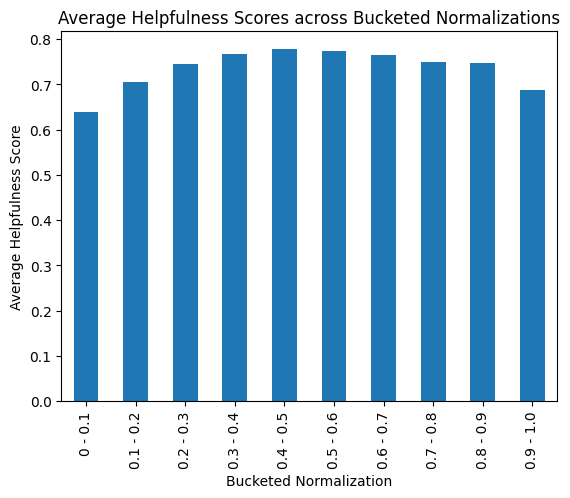

In [ ]:
# do not change this code -- this part is not graded, but just for you to see

# feel free to comment this out to help resolve large file hidden issues when submitting to Gradescope

from matplotlib import pyplot as plt
test_3_3_3_sdf.sort_values('bucketed_normalization').plot.bar(x='bucketed_normalization', y='average_helpfulness_score', legend=None)
plt.ylabel('Average Helpfulness Score')
plt.xlabel('Bucketed Normalization')
plt.title('Average Helpfulness Scores across Bucketed Normalizations')
plt.show()

### 3.4: Convert Unix Time! [2 pts]

As our final step in Section 3, we will convert the time column in `ratings_cleaned_data` to a DateTime variable for use in the next section.

The [`from_unixtime`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.from_unixtime.html) function should help with this

**TODO**:

*   Use Spark SQL to generate a new column
*   Define a new column, `cleaned_time` that converts the unix time (`time` column) to a DateTime object of the form "yyyy-MM-dd HH:mm:ss"
*   Store the results as `cleaned_time_reviews_sdf`

**Final Schema**: Include everything originally in `ratings_cleaned_data` with the addition of the `cleaned_time` column

In [ ]:
%%spark
query = '''
SELECT *,
       from_unixtime(time, "yyyy-MM-dd HH:mm:ss") AS cleaned_time
FROM ratings_cleaned_data;
'''

cleaned_time_reviews_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
cleaned_time_reviews_sdf.createOrReplaceTempView("test_3_4")
test_3_4_sdf = spark.sql('''SELECT * FROM test_3_4''')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_3_4_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test_3_4_sdf

,Id,Title,helpfulness,score,summary,text,no_of_reviews,positive_reviews,time,helpfulness_score,cleaned_time
0,1047604,Aurora Leigh,12/13,5.0,An amazing achievement,E.B.B. set out to outstrip Milton and does so ...,13.0,12.0,990316800,0.923077,2001-05-20
1,1047604,Aurora Leigh,2/2,1.0,Aurora Leigh from general books publishers,I bought this book (General Books edition) fro...,2.0,2.0,1310947200,1.000000,2011-07-18
2,1047604,Aurora Leigh,9/9,5.0,As If Jane Eyre Were Written by Shakespeare,Having been brought up on the notion that Eliz...,9.0,9.0,1130457600,1.000000,2005-10-28
3,1047604,Aurora Leigh,2/3,1.0,AWFUL copy of Aurora Leigh,This is the worst copy of a book I have ever s...,3.0,2.0,1318550400,0.666667,2011-10-14
4,1047655,The Prodigal Daughter,4/15,1.0,Extremly desapointing!!,"I first read ""Kane & Abel"" also by J. Archer, ...",15.0,4.0,1071446400,0.266667,2003-12-15
...,...,...,...,...,...,...,...,...,...,...,...
2495,2433389,Ice Station Zebra,4/4,5.0,Amazing atmosphere,The best thing about the writing in this book ...,4.0,4.0,1072137600,1.000000,2003-12-23
2496,2433389,Ice Station Zebra,3/4,5.0,Probably MacLean's Best,"First, Alistair MacLean is not one of my favor...",4.0,3.0,1192665600,0.750000,2007-10-18
2497,2433389,Ice Station Zebra,1/1,4.0,Murder On and Under the Ice,"Alistair MacLean's 1963 Cold War thriller ""Ice...",1.0,1.0,1170979200,1.000000,2007-02-09
2498,2433389,Ice Station Zebra,3/3,5.0,Tension and adventure under and on the polar i...,"Unlike some of this author's novels, Ice Stati...",3.0,3.0,1102204800,1.000000,2004-12-05


In [ ]:
# 2 points
grader.grade(test_case_id = 'test_unix_time', answer = test_3_4_sdf)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Step 4: Combining Books and Reviews Data [7 pts]

Congrats on making it this far!

This section will focus on combining the book data from part 2 and reviews data from part 3 (so fun!)

We want to use the dataset from 3.4, which cleaned the `time` column. Run the following cell to enable its use in Spark

In [ ]:
%%spark
cleaned_time_reviews_sdf.createOrReplaceTempView("ratings_cleaned_time_data")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Here, we will join `books_cleaned_data` with `ratings_cleaned_time_data` on `Title` and store the result in books_reviews_data

In [ ]:
%%spark
query = '''
SELECT *
FROM books_cleaned_data AS b JOIN ratings_cleaned_time_data AS r ON b.Title = r.Title
'''
books_reviews_sdf = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
books_reviews_sdf.createOrReplaceTempView("books_reviews_data")
books_reviews_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------------+-----------+----------+--------------------+-----------+-----+--------------------+--------------------+-------------+----------------+----------+-----------------+-------------------+
|               Title|             authors|          publisher| categories|        Id|               Title|helpfulness|score|             summary|                text|no_of_reviews|positive_reviews|      time|helpfulness_score|       cleaned_time|
+--------------------+--------------------+-------------------+-----------+----------+--------------------+-----------+-----+--------------------+--------------------+-------------+----------------+----------+-----------------+-------------------+
|'New Raiments of ...|Helen Bradley Foster|    Berg Publishers|     Design|1859731848|'New Raiments of ...|        1/2|  5.0|Definite Book on ...|Bradley Foster us...|          2.0|             1.0|1174262400|              0.5|2007-03-19 00:00:00|
|'New Ra

### 4.1 - Count number of reviews per author [3 pts]

`ratings_cleaned_time_data` contains a row for each review on a title. `books_cleaned_data` contains a row for each unique combination of publisher, book, and category.

We want to count the number of reviews associated with each author. Note: we will not be using the `no_of_reviews` column in this part. We are just trying to see the number of rows in `ratings_cleaned_time_data` that correspond to an author in `books_cleaned_data`.

**TODO**:


*   Use Spark SQL to find the total reviews associated with each author. Use `books_reviews_data`.
*   Sort the values by `review_count` in descending order and authors in alphabetical order
*   Save the result as `reviews_count_sdf`



**Final Schema**:
>authors | review_count
>--- | ---


**Hint**:
*  What value is unique to a review?

In [ ]:
%%spark
query = '''
SELECT authors,
       COUNT(DISTINCT text) AS review_count
FROM books_reviews_data
WHERE text IS NOT NULL and text <> ''
GROUP BY authors
ORDER BY review_count DESC, authors;
'''
reviews_count_sdf = spark.sql(query)
reviews_count_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------+
|        authors|review_count|
+---------------+------------+
|    Jane Austen|        3636|
|Charles Dickens|        3522|
|  Thomas Harris|        2775|
| John Steinbeck|        2740|
|   Stephen King|        2633|
+---------------+------------+
only showing top 5 rows

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
reviews_count_sdf.createOrReplaceTempView("test_4_1")
test_4_1_sdf = spark.sql('''SELECT * FROM test_4_1''')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_4_1_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
grader.grade(test_case_id = 'test_reviews_count', answer = test_4_1_sdf)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 4.2 - Most infuential authors between 2000 - 2005 [4 pts]

The `no_of_reviews` column tells you the number of people who responded to a particular book review. Think of it as the number of reviews for a review.

We want to measure the "influence" of an author by summing up these reviews of reviews to see how many total people have held opinions about a book. In this part, you will return the most influential author for each year from 2000-2005 (inclusive).

**TODO**:


*   Use Spark SQL and `books_reviews_data` to get the author with the most cumulative `no_of_reviews` (called `total_reviews`) per year.
*   Sort the values by `year` in ascending order
*   Save the result as `reviews_count_sdf`


**Final Schema**:
>year | authors | total_reviews
>--- | --- | ---

There should be six rows in the final result, each corresponding to a year.

**Hints**:
*  This is similar to part 2.2!
*  The YEAR() function can be used to get the year of a SQL datetime object

In [ ]:
%%spark

query = '''
WITH year_auth_rev AS (
  SELECT YEAR(cleaned_time) AS year,
         authors,
         SUM(no_of_reviews) AS total_reviews
  FROM books_reviews_data
  WHERE YEAR(cleaned_time) BETWEEN 2000 AND 2005
  GROUP BY year, authors
),

rnk_auth AS (
  SELECT year, authors, total_reviews,
         ROW_NUMBER() OVER (PARTITION BY year ORDER BY total_reviews DESC) AS author_rank
  FROM year_auth_rev
)

SELECT year, authors, total_reviews
FROM rnk_auth
WHERE author_rank = 1
ORDER BY year ASC;
'''
influential_authors_sdf = spark.sql(query)
influential_authors_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-------------------+-------------+
|year|            authors|total_reviews|
+----+-------------------+-------------+
|2000|        Jane Austen|       9477.0|
|2001|        Laura Doyle|       4485.0|
|2002|        David Brock|       9184.0|
|2003|      Alan Cambeira|      25455.0|
|2004|Laurell K. Hamilton|      12128.0|
|2005|        John Gibson|      24836.0|
+----+-------------------+-------------+

In [ ]:
#################     DO NOT EDIT      ##################
%%spark
influential_authors_sdf.createOrReplaceTempView("test_4_2")
test_4_2_sdf = spark.sql("SELECT * FROM test_4_2")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Convert to Pandas
%spark -o test_4_2_sdf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## AUTOGRADER
grader.grade(test_case_id = 'test_influential_authors', answer = test_4_2_sdf)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Step 5: Star Wars: Revenge of the Social Network [28 Pts]

In this section, we will be working with a dataset representing interactions between Star Wars characters from the film **[Star Wars: Episode I – The Phantom Menace](https://en.wikipedia.org/wiki/Star_Wars:_Episode_I_%E2%80%93_The_Phantom_Menace)**. In our table, each row represents an interaction between `Character1` and `Character2` from the film.

Let's introduce a fun little concept called the Bacon Number! The Bacon number of an actor or actress is the number of degrees of separation they have from actor Kevin Bacon, as defined by the game known as [**Six Degrees of Kevin Bacon**](https://en.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon). For example, Kevin Bacon's Bacon number is 0. If an actor works in a movie with Kevin Bacon, the actor's Bacon number is 1. If an actor works with an actor who worked with Kevin Bacon in a movie, the first actor's Bacon number is 2, and so forth.

How do we implement the *Super Bacon* score for our dataset though? We define this number as follows: if Person A follows Person B, and Person B follows Person C, then the *Super Bacon* score of C with respect to A will be 2.

To calculate this number, we'll use the concepts of graphs and BFS!

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=b378fc65cd6431462ec8840cb1c245fa4a85a6799a4316ec54985171c2c5ad33
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

appName = "PySpark"

# Create Spark session
spark = SparkSession.builder.appName(appName).getOrCreate()

### 5.1: “Traversing” a Graph [8 Pts]

Let's review how BFS works!

In [ ]:
import pandas as pd
from IPython.display import Image as I

bfsgif =\
'https://upload.wikimedia.org/wikipedia/commons/5/5d/Breadth-First-S'+\
'earch-Algorithm.gif'
dfsgif=\
'https://upload.wikimedia.org/wikipedia/commons/7/7f/Depth-First-Search.gif'


#### Intro to Breadth-First Search (BFS)


To start off, we will be implementing a graph traversal algorithm known as Breadth First Search. It works in a way that's equivalent to how a stain spreads on a white t-shirt. Take a look at the graph below:

<p align = "center">
<img src = "https://imgur.com/WU3AUwg.png" width= "600" align ="center"/>

* Consider starting BFS from point A (green). This is considered the starting frontier/singular **origin node**.
* The first round of BFS would involve finding all the nodes directly reachable from A, namely B-F (blue circles). These blue nodes make up the next frontier at depth 1 away from our starting node A.
* The second round would then be identifying the red nodes which are the neighbors of the blue nodes. Now, the red nodes all belong to a frontier 2 depth away from A. Note that node A is also a neighbor of a blue node. However, since it has already been visited, it does not get added to this frontier.

This process continues until all the nodes in the graph have been visited.
If you would like to learn more about BFS, we highly suggest looking [here](https://www.tutorialspoint.com/data_structures_algorithms/breadth_first_traversal.htm). **We also recommend watching and reviewing Recitation #6 material if you want a refresher on BFS.**


We will now be implementing `spark_bfs(G, N, d)`, our Spark flavor of BFS that takes:

1.   graph **G**
2.   set of origin nodes **N**
3.   max depth **d**.

In order to write a successful BFS function, you are going to need to figure out
1. How to keep track of nodes that we have visited
2. How to properly find all the nodes at the next depth
3. How to avoid cycles and ensure that we do not constantly loop through the same edges (take a look at J-K in the figure above)

#### BFS vs. DFS Animation
Run the code cells below to understand the difference between depth and breadth first search! (Source: Wikimedia Commons)

In [ ]:
# NOT GRADED
print('BFS:')
I(url=bfsgif)

BFS:


In [ ]:
# NOT GRADED
print('DFS:')
I(url=dfsgif)

DFS:


#### 5.1.1 Implement One BFS Traversal [6 Pts]

To break down this process, let's think about how we would implement a single traversal of the graph. Given the origin node, how are we going to get to the first wave of reachable nodes (i.e. nodes with distance 1 from the origin)?

Consider the simple example graph (**G**) below:

In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

simple = [('Arnav', 'Karan'),
          ('Arnav', 'Jeff'),
          ('Arnav', 'Federico'),
          ('Jeff', 'Liang'),
          ('Liang', 'Arnav'),
          ('Karan', 'Nicky'),
          ('Nicky', 'Yash'),
          ('Federico', 'Emily')]

simple_dict = {'from_node': ['Arnav', 'Arnav', 'Arnav', 'Jeff', 'Liang', 'Karan', 'Nicky', 'Federico'],
       'to_node': ['Karan', 'Jeff', 'Federico', 'Liang', 'Arnav', 'Nicky', 'Yash', 'Emily']}

simple_graph_df = pd.DataFrame.from_dict(simple_dict)
simple_graph_sdf = spark.createDataFrame(simple_graph_df)
simple_graph_sdf.show()

+---------+--------+
|from_node| to_node|
+---------+--------+
|    Arnav|   Karan|
|    Arnav|    Jeff|
|    Arnav|Federico|
|     Jeff|   Liang|
|    Liang|   Arnav|
|    Karan|   Nicky|
|    Nicky|    Yash|
| Federico|   Emily|
+---------+--------+



As you can see, each row of this dataframe represents an edge between two nodes. Here, we are looking at a **directed** graph, which means that Arnav --> Karan does not represent the same edge as Karan --> Arnav.

Let's define our starting node as follows:

In [ ]:
smallOrig = [{'node': 'Arnav'}]

Then, we perform BFS with graph **G**, starting from smallOrig (**N**) to depth (**d**) 1. If we implemented `spark_bfs(G, smallOrig, 1)`, the output would look like this:

In [ ]:
simple_1_round_dict = {'node': ['Karan', 'Federico', 'Jeff', 'Arnav'], 'distance': [1, 1, 1, 0]}
simple_1_round_bfs_df = pd.DataFrame.from_dict(simple_1_round_dict)
simple_1_round_bfs_sdf = spark.createDataFrame(simple_1_round_bfs_df)
simple_1_round_bfs_sdf.show()

+--------+--------+
|    node|distance|
+--------+--------+
|   Karan|       1|
|Federico|       1|
|    Jeff|       1|
|   Arnav|       0|
+--------+--------+



As you can see, this DataFrame logs each node with its corresponding distance away from Arnav. Moreover, we also know that these nodes are **visited**.

Hopefully, you can see how we can use our original graph and this new information to find the nodes at depth two.

This is exactly what we will try to accomplish with **spark_bfs_1_round(visited_nodes)** which will ultimately be the inner function of **spark_bfs** that we use to perform exactly one traversal of a graph.

**TODO**: Write **spark_bfs_1_round(visited_nodes)** that takes the currently dataframe of `visited_nodes`, performs one round of BFS, and returns an updated visited nodes dataframe.

*   Your input and output `visited_nodes` should have the columns *node* and *distance*

**Note**: You should assume that a temporary sdf **G** already exists. In other words, you can have access to **G** in your function.

**Hint:** It would very helpful to iterate one round of BFS using paper and pencil on `simple_1_round_bfs_sdf` with the given parameters in order to understand the problem.

In [ ]:
def spark_bfs_1_round(visited_nodes):
  """
  :param visited_nodes: dataframe with columns node and distance
  :return: dataframe of updated visited nodes, with columns node and distance
  """
  from pyspark.sql.functions import col

    # (1) From nodes in visited_nodes, go to the neighboring nodes
    # and increment distance by 1
    # (1) From nodes in visited_nodes, go to the neighboring nodes
    # and increment distance by 1
  visited_nodes = visited_nodes.alias('v').join(G, col('v.node') == col('from_node'), 'left') \
      .select(col('to_node').alias('node'), (col('v.distance') + 1).alias('distance')) \
      .union(visited_nodes)

  # (2) Remove duplicate entries, i.e. rows with the same node and distance
  visited_nodes = visited_nodes.dropDuplicates(['node', 'distance'])

  # (3) If there are two or more visited nodes with different distances, we want to
  # keep the minimum distance
  visited_nodes = visited_nodes.groupby('node').agg({'distance': 'min'}).withColumnRenamed('min(distance)', 'distance')

  return visited_nodes










Now, run the inner function on `simple_1_round_bfs_sdf` (i.e. result of 1 round of BFS on the simple graph) and store the results in simple_bfs_result. This is ultimately what the output of BFS to depth 2 should look like. Create your temporary sdf **G** and then call the `spark_bfs_1_round` function you created above.

**Note:** Your output should only have minimum distances and each node should only appear once.

In [ ]:
# TODO: Run spark_bfs_1_round on simple_1_round_bfs_sdf

G = simple_graph_sdf

# Running the spark_bfs_1_round function on simple_1_round_bfs_sdf
simple_bfs_result = spark_bfs_1_round(simple_1_round_bfs_sdf)
simple_bfs_result.show()

+--------+--------+
|    node|distance|
+--------+--------+
|   Emily|       2|
|   Nicky|       2|
|   Liang|       2|
|Federico|       1|
|   Karan|       1|
|    Jeff|       1|
|   Arnav|       0|
+--------+--------+



**TODO**:

Convert this result to Pandas, sort by distance column in ascending order, and submit it to the autograder.

**Hint**: Check out the `toPandas()` function [documentation](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html).

In [ ]:
# TODO: Convert simple_bfs_result to Pandas and sort by distance ascending order
simple_bfs_test = simple_bfs_result.toPandas().sort_values('distance', ascending=True)


In [ ]:
### DO NOT EDIT
simple_bfs_test = simple_bfs_test.reset_index(drop=True)

In [ ]:
simple_bfs_test

,node,distance
0,Arnav,0
1,Federico,1
2,Karan,1
3,Jeff,1
4,Emily,2
5,Nicky,2
6,Liang,2


In [ ]:
# 6 points
grader.grade(test_case_id = 'checksimpleBFS', answer = simple_bfs_test)

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 5.1.2 Full BFS Implementation [2 Pts]

Now, we will fully implement **spark_bfs**. This function should iteratively call your implemented version of **spark_bfs_1_round** and ultimately return the output of this function at **max_depth**.

You are also responsible for initializing the starting dataframe, that is converting the list of origin nodes into a spark dataframe with the nodes logged at distance 0.

Consider the following:

```
schema = StructType([
            StructField("node", StringType(), True)
        ])

    my_sdf = spark.createDataFrame(origins, schema)
```

The schema ultimately specifies the structure of the Spark DataFrame with a string `node` column. It then calls **spark.createDataFrame** to map this schema to the **origins** nodes. Also, you are responsible for ensuring that a view of your graph is available within this function. (Note: you will also need to add in a distance column)

**TODO:** Implement `spark_bfs(G,origins,max_depth)`. In the coming sections, you will run this function on `star_wars_sdf` that you will initialize in 5.2.

**Note:** you may want to run tests on the **simple_graph** example as the `star_wars_sdf` will take quite some time to run.

Also remember that in section 5.1.1, we had assumed that the temporary view already exists. So you will have to take care of creating that within this function.

These imports might be useful:
`from pyspark.sql.types import StructType, StructField, StringType, IntegerType`

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, Row
# TODO: iterative search over undirected graph
# NOTE: This function will also be used in 5.3

def spark_bfs(G, origins, max_depth):
  """ runs distributed BFS to a specified max depth

  :param G: graph dataframe from 5.1.1
  :param origins: list of origin nodes stored as {"node": nodeValue}
  :param max_depth: integer value of max depth to run BFS to
  :return: dataframe with columns node, distance of all visited nodes
  """

  schema = StructType([
        StructField("node", StringType(), True),
        StructField("distance", IntegerType(), True)
    ])
  visited_nodes = spark.createDataFrame([], schema)

  # (2) Initialize nodes_visited
  for orig in origins:
      visited_nodes = visited_nodes.union(spark.createDataFrame([Row(node=orig["node"], distance=0)]))

  # (3) Iterate BFS
  for i in range(max_depth):
      visited_nodes = spark_bfs_1_round(visited_nodes)

  visited_nodes = visited_nodes.filter(visited_nodes.node.isNotNull())
  return visited_nodes








Test that this function works on a simple example.

In [ ]:
### SELF CHECK: You will know your spark_bfs works if it passes autograder

### DO NOT EDIT
simple_bfs_iterative_result = spark_bfs(simple_graph_sdf, smallOrig, 3)
simple_bfs_iterative_result.show()

+--------+--------+
|    node|distance|
+--------+--------+
|   Arnav|       0|
|   Liang|       2|
|Federico|       1|
|   Emily|       2|
|   Nicky|       2|
|    Yash|       3|
|   Karan|       1|
|    Jeff|       1|
+--------+--------+



In [ ]:
# 2 points
grader.grade(test_case_id = 'iterBFS', answer = simple_bfs_iterative_result.toPandas())

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 5.2: In a Network Far, Far Away [8 Pts]

**Read:** Download the `star_wars.csv` dataset from [here](https://drive.google.com/file/d/1d8t3AJ1WnF4XzeJsDx6g4q2lgOgHjsCT/view?usp=sharing), and upload it to the directory in Google Drive where you are storing your HW3 notebook.

#### 5.2.1: Loading and Viewing Data


TODO: Mount your Google Drive and then edit the directory link to where you are storing the `star_wars.csv`.

In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TODO: modify the directory to where star_wars.csv is stored
path = "/content/drive/My Drive/Colab Notebooks/star_wars.csv" # path of file in Google Drive
star_wars_sdf = spark.read.csv(path, header=True)

Let's load the data to `star_wars_sdf` and see how it looks.

In [ ]:
# display star_wars_sdf
star_wars_sdf.show()

+---+--------------+-----------+
|_c0|    Character1| Character2|
+---+--------------+-----------+
|  0|   NUTE GUNRAY|    QUI-GON|
|  1|          PK-4|      TC-14|
|  2|       OBI-WAN|      TC-14|
|  3|       QUI-GON|      TC-14|
|  4|       OBI-WAN|    QUI-GON|
|  5|   NUTE GUNRAY|      TC-14|
|  6|        DOFINE|NUTE GUNRAY|
|  7|        DOFINE|      TC-14|
|  8|   NUTE GUNRAY|       RUNE|
|  9|          RUNE|    TEY HOW|
| 10|   NUTE GUNRAY|    TEY HOW|
| 11|CAPTAIN PANAKA|    EMPEROR|
| 12|       EMPEROR| SIO BIBBLE|
| 13|CAPTAIN PANAKA| SIO BIBBLE|
| 14|       JAR JAR|    QUI-GON|
| 15|       JAR JAR|    OBI-WAN|
| 16|       JAR JAR|    TARPALS|
| 17|     BOSS NASS|    QUI-GON|
| 18|     BOSS NASS|    OBI-WAN|
| 19|     BOSS NASS|    JAR JAR|
+---+--------------+-----------+
only showing top 20 rows



#### 5.2.2: Characters with the Most Interactions with Others [6 Pts]

As we can see, the DataFrame consists of 2 columns named Character1 and Character1. These columns indicate an edge in the social network graph formed when two characters directly interact with each other in the film. Each row in the dataframe indicates that Character1 interacts with Character2.

**READ: For this subproblem (5.2.2) ONLY**, we are going to assume that each interaction or link is **undirected**, meaning the source or target nodes are arbitrarily assigned and that A --> B is the same as B --> A.

We want to find out which character interacted with the most number of unique characters in the film.

***TODO***:
1.   Create a DataFrame with the columns *Character* and *Unique_Interactions* from `star_wars_sdf`, in which *Character* is the name of the character and *Unique_Interactions* represents the number of unique chracters that the given character had interacted with.  
2.   The final DataFrame `count_sdf` should be sorted in descending order based on Interactions_Count.
3.   Convert `count_sdf` to a Pandas DataFrame `count_df`.

**Hint #1**: Each interaction is **undirected**, meaning it is a two-way relationship. Think about what that means for your calculation.

**Hint #2**: You may find the `UNION ALL` command useful.

**Hint #3**: Refer to HW2 if you get stuck!


In [ ]:
# TODO: Design your query

star_wars_sdf.createOrReplaceTempView('star_wars_table')

query = """
SELECT Character, SUM(Unique_Interactions) as Unique_Interactions
FROM (
  SELECT Character1 as Character, COUNT(DISTINCT Character2) as Unique_Interactions
  FROM star_wars_table
  GROUP BY Character1
  UNION ALL
  SELECT Character2 as Character, COUNT(DISTINCT Character1) as Unique_Interactions
  FROM star_wars_table
  GROUP BY Character2
)
GROUP BY Character
ORDER BY Unique_Interactions DESC
"""

count_sdf = spark.sql(query)
count_sdf.show()

+--------------+-------------------+
|     Character|Unique_Interactions|
+--------------+-------------------+
|       QUI-GON|                 25|
|        ANAKIN|                 22|
|       JAR JAR|                 18|
|         PADME|                 17|
|       OBI-WAN|                 13|
|       EMPEROR|                 11|
|   NUTE GUNRAY|                 10|
|CAPTAIN PANAKA|                  9|
|       KITSTER|                  8|
|          SHMI|                  8|
|         JABBA|                  7|
|    SIO BIBBLE|                  7|
|      RIC OLIE|                  7|
|    MACE WINDU|                  6|
|     BOSS NASS|                  6|
|       SEBULBA|                  6|
|  KI-ADI-MUNDI|                  6|
|          YODA|                  6|
|         C-3PO|                  5|
|          RABE|                  5|
+--------------+-------------------+
only showing top 20 rows



In [ ]:
# TODO: Convert your count_sdf results to Pandas dataframe count_df
count_df = count_sdf.toPandas()

In [ ]:
# display top ten characters with the most interactions
count_df.head(10)

,Character,Unique_Interactions
0,QUI-GON,25
1,ANAKIN,22
2,JAR JAR,18
3,PADME,17
4,OBI-WAN,13
5,EMPEROR,11
6,NUTE GUNRAY,10
7,CAPTAIN PANAKA,9
8,KITSTER,8
9,SHMI,8


In [ ]:
# 6 points
grader.grade(test_case_id = 'checkInteractionsCount', answer = count_df)

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 5.2.3: Convert Data into Graph [2 Pts]

**READ: For this subproblem (5.2.3) ONLY**, we are going to assume that each interaction or link is **directed**, meaning the source or target nodes are intenionally assigned and that A --> B is **NOT** the same as B --> A. `Character1` will be the source node and `Character2` will be the target node.

Using `star_wars_sdf`, let's convert it to a graph sdf.

**TODO:** From **star_wars_graph_sdf**, rename columns to `from_node` and `to_node`.

*   `from_node` has all the entries from the `Character1` column
*    `to_node` has all the entries from the `Character2` column

In [ ]:
# TODO: using star_wars_df, create star_wars_sdf with the appropriate columns
star_wars_sdf.createOrReplaceTempView('interactions')

query = "SELECT Character1 AS from_node, Character2 AS to_node FROM interactions"

star_wars_graph_sdf = spark.sql(query)
star_wars_graph_sdf.show()

+--------------+-----------+
|     from_node|    to_node|
+--------------+-----------+
|   NUTE GUNRAY|    QUI-GON|
|          PK-4|      TC-14|
|       OBI-WAN|      TC-14|
|       QUI-GON|      TC-14|
|       OBI-WAN|    QUI-GON|
|   NUTE GUNRAY|      TC-14|
|        DOFINE|NUTE GUNRAY|
|        DOFINE|      TC-14|
|   NUTE GUNRAY|       RUNE|
|          RUNE|    TEY HOW|
|   NUTE GUNRAY|    TEY HOW|
|CAPTAIN PANAKA|    EMPEROR|
|       EMPEROR| SIO BIBBLE|
|CAPTAIN PANAKA| SIO BIBBLE|
|       JAR JAR|    QUI-GON|
|       JAR JAR|    OBI-WAN|
|       JAR JAR|    TARPALS|
|     BOSS NASS|    QUI-GON|
|     BOSS NASS|    OBI-WAN|
|     BOSS NASS|    JAR JAR|
+--------------+-----------+
only showing top 20 rows



In [ ]:
# 4 points
grader.grade(test_case_id = 'checkStarWarsGraph', answer = star_wars_graph_sdf.toPandas())

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 5.3: Boss Nass Search [12 Pts]

Let's find out the Super Bacon score with respect to the character `BOSS NASS`. You will use the `spark_bfs` that you created earlier in section 5.1.2 for this problem.

**TODO:**
*   Initialize your orignal node with variable `orig`
*   Run your spark_bfs function with the correct arguments. Sort the resulting table in descending order based on the column `distance`.
    *   The `orderBy` [function](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.orderBy.html) may be helpful.
*   Save your final table as `bfs_boss_nass_sdf`.
*   Convert `bfs_boss_nass_sdf` to a Pandas DataFrame `bfs_boss_nass_df`.
*   Save the character with the highest score as a string in the variable `highest_bacon_scorer`. **Do not hardcode your answer.**





In [ ]:
# TODO: initialize your origin node
orig = [{"node": "BOSS NASS"}]

In [ ]:
# 2 points
grader.grade(test_case_id = 'checkBFS1', answer = orig)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
### RUN CELL, DO NOT EDIT
depth = 4

In [ ]:
# TODO: Perform BFS using spark_bfs for the given amount of depth, the star_wars_graph_sdf, and the origin node
# save results in bfs_boss_nass_sdf

G = star_wars_graph_sdf
bfs_boss_nass_sdf = spark_bfs(star_wars_graph_sdf, orig, depth)
bfs_boss_nass_sdf = bfs_boss_nass_sdf.orderBy(bfs_boss_nass_sdf['distance'].desc())
bfs_boss_nass_sdf.show()

+------------+--------+
|        node|distance|
+------------+--------+
|     TEY HOW|       4|
|        RUNE|       3|
|GENERAL CEEL|       3|
| NUTE GUNRAY|       3|
|     TARPALS|       2|
|        WALD|       2|
|  SIO BIBBLE|       2|
|     KITSTER|       2|
|     EMPEROR|       2|
|        YODA|       2|
|     VALORUM|       2|
|       TC-14|       2|
|       WATTO|       2|
|     SEBULBA|       2|
|    RIC OLIE|       2|
|        RABE|       2|
|        SHMI|       2|
|       PADME|       1|
|     OBI-WAN|       1|
|     QUI-GON|       1|
+------------+--------+
only showing top 20 rows



In [ ]:
# TODO: Convert to Pandas dataframe
bfs_boss_nass_df = bfs_boss_nass_sdf.toPandas()

In [ ]:
# 6 points
grader.grade(test_case_id = 'checkBFS2', answer = bfs_boss_nass_df)

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
# display top 5 rows
bfs_boss_nass_df.head(5)

,node,distance
0,TEY HOW,4
1,RUNE,3
2,GENERAL CEEL,3
3,NUTE GUNRAY,3
4,TARPALS,2


In [ ]:
# TODO: Report and save the character (string) with the highest score in highest_bacon_scorer
# Do not hardcode your answer

highest_bacon_scorer = bfs_boss_nass_df.loc[bfs_boss_nass_df['distance'].idxmax()]['node']
highest_bacon_scorer

'TEY HOW'

In [ ]:
# 4 points
grader.grade(test_case_id = 'checkBFS3', answer = highest_bacon_scorer)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# HW Submission

Before you submit on Gradescope (you must submit your notebook to receive credit):


1.   Restart and Run-All to make sure there's nothing wrong with your notebook
2.   **Double check that you have the correct PennID (all numbers) in the autograder**.
3. Make sure you've run all the PennGrader cells
4. Go to the "File" tab at the top left, and click "Download .ipynb" and then "Download .py".  **Rename** the files to "homework3.ipynb" and "homework3.py" respectively and upload them to Gradescope

**Let the course staff know ASAP if you have any issues submitting, but otherwise best of luck!**

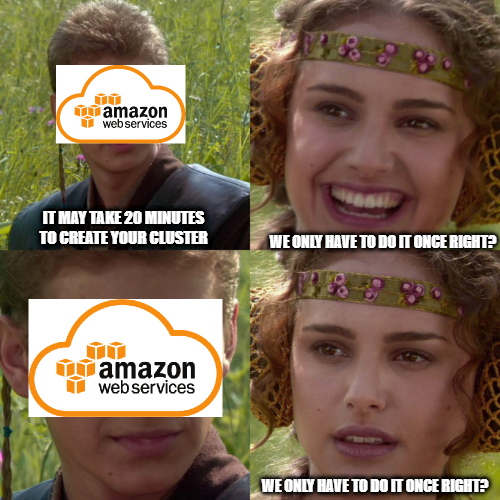